In [67]:
import numpy as np
from sklearn.cluster import KMeans, MeanShift
import pandas as pd
from bokeh.plotting import figure, output_notebook, show
from scipy import stats
import matplotlib.pyplot as plt
import random
output_notebook()

Loading BokehJS ...

DNA sequencing is a powerful tool that allows scientists to determine the order of nucleotides within a DNA strand. However, the human genome, for example, is an incredibly long strand that is made up of billions of nucleotides. Most DNA sequencing technologies cannot sequence an entire genome all at once, so the genome needs to be duplicated and broken down into smaller fragments that can be sequenced. This process is called DNA fragmentation.

DNA fragmentation involves duplicating the genome many times and then breaking it apart into smaller fragments, typically around 100-150 nucleotides long. Each of these fragments is sequenced individually, and the resulting sequence is called a "read." DNA sequencing generates millions of these reads for a single genome.

After sequencing, the next step is to map the reads back to a reference genome, which is a well-defined sequence for a particular species. This mapping process involves aligning each read to the reference genome to determine its location in the genome. When a read maps to a particular location in the genome, it provides information about the nucleotide sequence at that location.

Once the reads have been mapped to the reference genome, researchers can use a process called binning to analyze the data. Binning involves dividing the genome into non-overlapping segments of a fixed size (i.e., bins) and counting the number of reads that map to each bin. The size of the bins can vary depending on the desired resolution of the analysis.

By binning the genome based on read counts, researchers can gain insights into the distribution of reads across the genome. Binning allows researchers to identify regions of the genome that are highly expressed, silenced, or show altered expression patterns in different tissues or under different experimental conditions. Binning also allows researchers to identify genes and regulatory elements that are important for particular biological processes.

Overall, DNA sequencing, DNA fragmentation, read mapping, and binning are essential steps in the analysis of DNA sequencing data. They allow researchers to obtain a high-resolution view of the structure and function of the genome and provide valuable insights into the mechanisms that underlie biological processes.

Because geneomics data is extremely large and noisy, we will be working off of simulated data:

In [68]:
# This is a function that simulated read count data per bin. Here num_bins is the number of bins for the entire geneome. 
# For example, if num_bins=5000 and we are wroking with the human geneome which has 3.2 billion nucleotides
# then each bin represents a sequence of 640,000 nucleotides and the number of reads mapped to each of these 5,000 regions.
np.random.seed(56)
random.seed(56)
def generate_read_count_bin_data(num_bins):
  segment_lengths = []
  total = int(num_bins)
  while True:
    seg = int(np.random.normal(100, 2))
    total -= seg
    if total > 0:
      segment_lengths.append(seg)
    else:
      segment_lengths.append(num_bins - sum(segment_lengths))
      break
  copy_number_states = np.random.geometric(0.5, size=len(segment_lengths))
  read_counts = []
  for i in range(0, len(segment_lengths)):
    for j in range(segment_lengths[i]):
      read_counts.append(copy_number_states[i] + random.uniform(0, 0.5))
  graph = figure(title = "Read Count Data Per Bin")

  graph.scatter(list(range(num_bins)), read_counts)
  graph.xaxis.axis_label = 'Bin Number'
  graph.yaxis.axis_label = 'Number of Reads (Thousands)'
  show(graph)

  return read_counts

Here I am generating read count data for a total of `5000` bins. Each bin corresponds to the number of reads that were mapped to that bin. Feel free to zoom into the data points using the box zoom button on the right toolbar (this is an interactive plot).

In [69]:
read_counts = generate_read_count_bin_data(5000)

Notice how in this read count data (above) there is a good amount of fluctuation. In the first few bins there are only about 1000ish reads but other bins have almost 5000ish with some as many as 7000ish. What does this mean?

Fluctuations in read counts per bin can provide important information about copy numbers in the genome. Copy number refers to the number of copies of a particular segment of DNA that are present in a cell's genome. Copy number variations (CNVs) can occur when the number of copies of a particular segment of DNA varies between individuals or within a population.

When read counts per bin fluctuate, it may indicate that the copy number of that region of the genome is variable. For example, if a particular bin has a higher than average read count, it may suggest that there are multiple copies of that region of the genome present in the cell. Conversely, if a bin has a lower than average read count, it may suggest that there are fewer copies of that region of the genome present in the cell.

By analyzing read counts per bin across the genome, researchers can identify regions that have variable copy numbers. These regions may be associated with genetic disorders or other diseases, and understanding their copy number status can provide important insights into the underlying biology of these conditions.

Furthermore, changes in copy number are an important source of genetic variation that can have significant implications for cancer development and progression. As a result being able to detect which regions of the geneome correspond to a significant change in copy number is cruical. ***And guess what... this can be accomplished with clustering!!! ***

1) To do this walk through the entire read count data taking into consideration every 20 bins. 

2) Then perform a KMneas culster to get two clusters. 

3) Then conduct a t-test between the two clusters to see if there is a significant difference between those data points. If there is mark the bin number this occurs in, else continue.

4) Keep doing this until you run through the entire dataset. And we off set by 10 everytime.

Look at images below for more detail.

In this set of data we first consider the first 100 bins

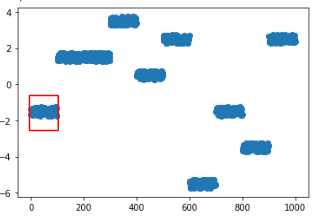

There we do a KMeans culstering with two cluster on this data (centriods in yellow)

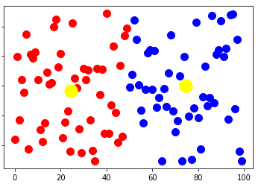

The t-test shows that the clusters are not significantly different from each other.

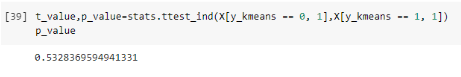

We then look at the next set of 100 bins (offset by 50) so we are looking at bins 50-150

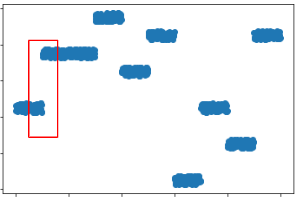

Then we cluster again ...

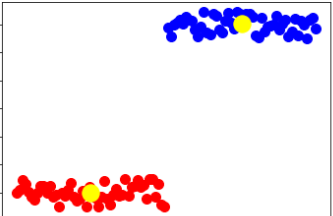

Teh t-test shows that there is a significant difference between the data so bin 100 is added to our return list

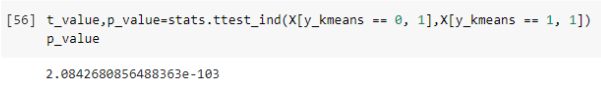

Now we repeat through the entire data.

In [70]:
from scipy.cluster.vq import kmeans2
from scipy.stats import ttest_ind
from bokeh.plotting import figure, show

# Function to cluster and test read counts in sliding windows
def cluster_and_test_read_counts(read_counts, window_size=20, offset=10):
    
    # Initialize variables to store results
    bin_numbers = []    # bin numbers with significant differences
    p_values = []       # corresponding p-values
    cluster_labels = [] # labels assigned by clustering algorithm
    
    # Iterate through the read counts in sliding windows
    for i in range(0, len(read_counts), offset):
        
        # Break loop if end of read_counts is reached
        if i + window_size > len(read_counts):
            break
        
        # Extract window of read counts
        window = np.array(read_counts[i:i+window_size])
        
        try:
            # Cluster window using k-means algorithm
            centroids, labels = kmeans2(window, k=2)
            
            # Add cluster labels to list of all labels
            cluster_labels += list(labels)
            
            # Split window into two clusters
            cluster1 = window[labels == 0]
            cluster2 = window[labels == 1]
            
            # Test for significant difference between clusters
            t, p = ttest_ind(cluster1, cluster2)
            
            # If p-value is significant, record bin number with maximum read count
            if p < 0.05:
                bin_numbers.append(i + np.argmax(window))
                p_values.append(p)
        
        # Ignore any errors that occur during clustering
        except:
            pass
    
    # Return results as tuple
    return bin_numbers, p_values, cluster_labels

In [71]:
# Generate read count data
read_counts = generate_read_count_bin_data(5000)

In [72]:
# Cluster and test read counts in sliding windows
bin_numbers, p_values, cluster_labels = cluster_and_test_read_counts(read_counts)

In [73]:
if len(bin_numbers) == 0:
    print("No significant differences were found.")
else:
    print(f"Significant differences were found in {len(bin_numbers)} windows.")
    print("Bin numbers:", bin_numbers)
    print("P-values:", p_values)

Significant differences were found in 489 windows.
Bin numbers: [1, 16, 21, 43, 43, 67, 77, 77, 91, 91, 108, 122, 122, 146, 146, 168, 168, 183, 197, 202, 202, 219, 237, 237, 255, 255, 279, 279, 285, 294, 308, 318, 331, 346, 346, 353, 373, 373, 398, 404, 404, 424, 424, 445, 445, 464, 470, 470, 485, 497, 519, 519, 529, 547, 547, 562, 562, 589, 599, 619, 619, 635, 635, 650, 650, 674, 674, 681, 691, 700, 715, 731, 746, 757, 757, 778, 778, 780, 797, 815, 815, 837, 837, 841, 860, 870, 887, 899, 903, 913, 913, 936, 936, 952, 952, 974, 974, 990, 1006, 1021, 1030, 1030, 1044, 1051, 1077, 1077, 1099, 1117, 1124, 1124, 1149, 1152, 1152, 1175, 1181, 1202, 1217, 1220, 1220, 1248, 1253, 1267, 1267, 1270, 1289, 1293, 1305, 1314, 1334, 1347, 1347, 1366, 1366, 1380, 1390, 1408, 1408, 1422, 1422, 1436, 1457, 1457, 1477, 1477, 1498, 1519, 1527, 1535, 1535, 1549, 1563, 1563, 1588, 1588, 1593, 1615, 1615, 1639, 1639, 1656, 1656, 1679, 1689, 1690, 1690, 1707, 1725, 1725, 1748, 1748, 1762, 1762, 1787, 1799, 

In [74]:
# Generate scatter plot
graph = figure(title="Read Count Data Per Bin", width=800, height=500)
graph.scatter(list(range(len(read_counts))), read_counts, color=['red' if label == 0 else 'blue' for label in cluster_labels])
graph.xaxis.axis_label = 'Bin Number'
graph.yaxis.axis_label = 'Number of Reads (Thousands)'

# Add red dots to indicate significant differences
graph.scatter(bin_numbers, np.zeros(len(bin_numbers)), color='red', size=10)

show(graph)